In [88]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

import p2_FMP_Requests as fmp
import machine_learning_model as mlm
import backtest as bt

import warnings
warnings.filterwarnings('ignore')


In [112]:
import pandas as pd
from dotenv import load_dotenv
import os
import p2_FMP_Requests as fmp
from pathlib import Path


# load api key for financialmodelingprep.com from .env file
load_dotenv()
apikey = os.getenv("FMP_API_KEY")




In [114]:
ticker = 'NVDA'

NVDA_hist_price_response = fmp.get_historical_stock_price_5min(ticker, apikey)
NVDA_df = pd.DataFrame(NVDA_hist_price_response).set_index('date').sort_index(ascending=True)

NVDA_df

,open,low,high,close,volume
date,,,,,
2022-09-19 09:30:00,130.1200,130.1000,133.25,132.9150,2500239
2022-09-19 09:35:00,132.9299,132.1000,133.39,132.4800,1534103
2022-09-19 09:40:00,132.4900,132.2165,133.05,132.3944,1855687
2022-09-19 09:45:00,132.4100,131.8000,132.89,131.9000,1189078
2022-09-19 09:50:00,131.9100,131.8700,132.76,132.6800,1098068
...,...,...,...,...,...
2022-09-28 15:40:00,127.6001,127.6001,127.86,127.7290,633754
2022-09-28 15:45:00,127.7100,127.6300,128.07,127.9500,729317
2022-09-28 15:50:00,127.9500,127.6700,128.23,127.9400,855118


In [89]:
# Import the OHLCV dataset into a Pandas Dataframe
stock_data_df = pd.read_csv(
    Path("./Resources/NVDA_data.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
stock_data_df.head()

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,changeOverTime,marketCap,dcf
date,,,,,,,,,,,,,
2018-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273.125136
2018-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267.425136
2018-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.595136
2018-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.845136
2018-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269.555136


In [90]:
stock_data_df.dtypes

open                float64
high                float64
low                 float64
close               float64
adjClose            float64
volume              float64
unadjustedVolume    float64
change              float64
changePercent       float64
vwap                float64
changeOverTime      float64
marketCap           float64
dcf                 float64
dtype: object

In [91]:
# Filter the date index and close columns
signals_df = stock_data_df.loc[:, ["close"]].dropna()

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())


,close,Actual Returns
date,,
2018-10-10,61.422501,-0.074753
2018-10-11,58.782501,-0.042981
2018-10-12,61.634998,0.048526
2018-10-15,58.845001,-0.045266
2018-10-16,61.457501,0.044396


,close,Actual Returns
date,,
2022-09-22,125.610001,-0.052786
2022-09-23,125.160004,-0.003582
2022-09-26,122.279999,-0.023011
2022-09-27,124.130000,0.015129
2022-09-28,127.360000,0.026021


In [92]:
# Set the short window and long window
short_window = 50
long_window = 300

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2019-12-18,57.377499,0.005344,51.73850,43.510492
2019-12-19,58.865002,0.025925,52.01225,43.501967
2019-12-20,59.842499,0.016606,52.29395,43.505500
2019-12-23,59.705002,-0.002298,52.55810,43.499067
2019-12-24,59.654999,-0.000838,52.81855,43.501767


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2022-09-22,125.610001,-0.052786,163.167999,218.373825
2022-09-23,125.160004,-0.003582,162.596799,218.185658
2022-09-26,122.279999,-0.023011,161.889999,217.967267
2022-09-27,124.130000,0.015129,161.152399,217.760633
2022-09-28,127.360000,0.026021,160.301199,217.538167


In [93]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = -1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2019-12-18,57.377499,0.005344,51.73850,43.510492,-1.0
2019-12-19,58.865002,0.025925,52.01225,43.501967,-1.0
2019-12-20,59.842499,0.016606,52.29395,43.505500,-1.0
2019-12-23,59.705002,-0.002298,52.55810,43.499067,1.0
2019-12-24,59.654999,-0.000838,52.81855,43.501767,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2022-09-22,125.610001,-0.052786,163.167999,218.373825,1.0
2022-09-23,125.160004,-0.003582,162.596799,218.185658,1.0
2022-09-26,122.279999,-0.023011,161.889999,217.967267,1.0
2022-09-27,124.130000,0.015129,161.152399,217.760633,-1.0
2022-09-28,127.360000,0.026021,160.301199,217.538167,-1.0


In [94]:
signals_df['Signal'].value_counts()

-1.0    378
 1.0    322
Name: Signal, dtype: int64

In [95]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2019-12-18,57.377499,0.005344,51.73850,43.510492,-1.0,NaN
2019-12-19,58.865002,0.025925,52.01225,43.501967,-1.0,-0.025925
2019-12-20,59.842499,0.016606,52.29395,43.505500,-1.0,-0.016606
2019-12-23,59.705002,-0.002298,52.55810,43.499067,1.0,0.002298
2019-12-24,59.654999,-0.000838,52.81855,43.501767,1.0,-0.000838


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2022-09-22,125.610001,-0.052786,163.167999,218.373825,1.0,0.052786
2022-09-23,125.160004,-0.003582,162.596799,218.185658,1.0,-0.003582
2022-09-26,122.279999,-0.023011,161.889999,217.967267,1.0,-0.023011
2022-09-27,124.130000,0.015129,161.152399,217.760633,-1.0,0.015129
2022-09-28,127.360000,0.026021,160.301199,217.538167,-1.0,-0.026021


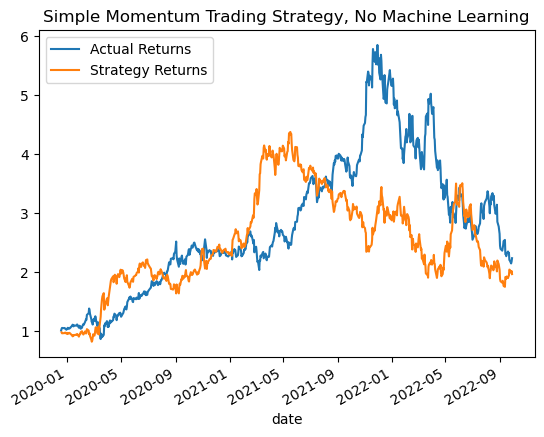

In [96]:
# Plot Strategy Returns to examine performance
(1 + signals_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot(title='Simple Momentum Trading Strategy, No Machine Learning')
plt.savefig('./images/no_ml_strategy.png')

In [97]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2019-12-19,51.73850,43.510492
2019-12-20,52.01225,43.501967
2019-12-23,52.29395,43.505500
2019-12-24,52.55810,43.499067
2019-12-26,52.81855,43.501767


In [98]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

-1.0    378
 1.0    322
Name: Signal, dtype: int64

In [99]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-12-19 00:00:00


In [100]:
# Select the ending period for the training data with an offset of 18 months
training_end = X.index.min() + DateOffset(months=18)

# Display the training end date
print(training_end)

2021-06-19 00:00:00


In [101]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2019-12-19,51.73850,43.510492
2019-12-20,52.01225,43.501967
2019-12-23,52.29395,43.505500
2019-12-24,52.55810,43.499067
2019-12-26,52.81855,43.501767


In [102]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(day=1):]
y_test = y.loc[training_end+DateOffset(day=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2021-06-01,145.053749,119.457000
2021-06-02,145.737499,119.821909
2021-06-03,146.455899,120.173534
2021-06-04,147.235699,120.534509
2021-06-07,148.222749,120.906084


In [103]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [104]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [105]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.51      1.00      0.67       171
         1.0       0.00      0.00      0.00       165

    accuracy                           0.51       336
   macro avg       0.25      0.50      0.34       336
weighted avg       0.26      0.51      0.34       336



In [106]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Actual Returns'] * predictions_df['Predicted'])

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2021-06-01,-1.0,0.001231,-0.001231
2021-06-02,-1.0,0.031587,-0.031587
2021-06-03,-1.0,0.011414,-0.011414
2021-06-04,-1.0,0.035858,-0.035858
2021-06-07,-1.0,0.002318,-0.002318


,Predicted,Actual Returns,Strategy Returns
date,,,
2022-09-22,-1.0,-0.052786,0.052786
2022-09-23,-1.0,-0.003582,0.003582
2022-09-26,-1.0,-0.023011,0.023011
2022-09-27,-1.0,0.015129,-0.015129
2022-09-28,-1.0,0.026021,-0.026021


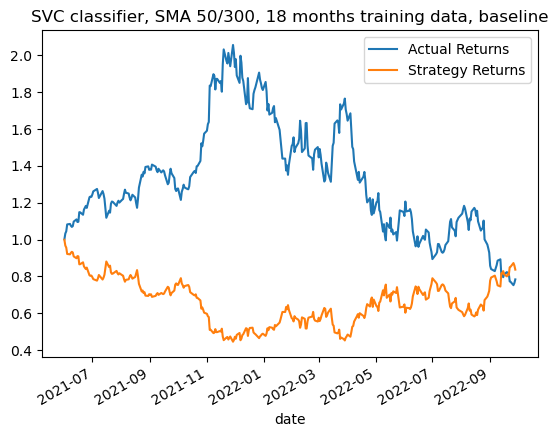

In [107]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot(title='SVC classifier, SMA 50/300, 18 months training data, baseline')
# plt.savefig('./images/ml_svc_4_100_3mths_baseline.png')
# plt.savefig('./images/ml_svc_4_100_6mths.png')
# plt.savefig('./images/ml_svc_4_100_9mths.png')
# plt.savefig('./images/ml_svc_50_300_6mths.png')
plt.savefig('./images/ml.png')
